In [1]:
import nltk
from nltk.corpus import webtext
from collections import Counter
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer, SnowballStemmer


In [2]:
text = webtext.raw('firefox.txt')
tokens = nltk.word_tokenize(text)
vocabulary = Counter(tokens)
print("Vocabulary size: ", len(vocabulary))

Vocabulary size:  9300


In [3]:
Porter = PorterStemmer()
snowball_stemmer = [Porter.stem(word) for word in tokens]
print("Porter Stemmer vocabulary size: ", set(snowball_stemmer).__len__())

Snowball = SnowballStemmer("english")
snowball_stemmer = [Snowball.stem(word) for word in tokens]
print("Snowball Stemmer vocabulary size: ", set(snowball_stemmer).__len__())

Porter Stemmer vocabulary size:  5847
Snowball Stemmer vocabulary size:  5702


In [4]:
stopwords = stopwords.words('english')

In [5]:
vocab_stopwords = set(word for word in tokens if not word in stopwords)
print("The len of the vocabulary without stopwords is: ", len(vocab_stopwords))

The len of the vocabulary without stopwords is:  9187


In [6]:
own_stopowrds = stopwords
own_stopowrds.append('I')
vocab_stopwords_own = set(word for word in tokens if not word in own_stopowrds)
print("The len of the vocabulary without stopwords is: ", len(vocab_stopwords_own))

The len of the vocabulary without stopwords is:  9186


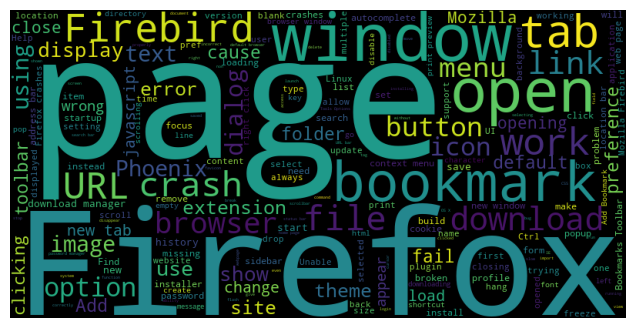

In [7]:
## Simple WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 


def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(
                          width=800, height=400,
                          relative_scaling = 1.0,
                          stopwords = STOPWORDS,
                          ).generate(text)
    
    fig = plt.figure(1, figsize=(8, 4))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.axis("off")
    ## Pick One:
    # plt.show()
    plt.savefig("WordCloud.png")

generate_wordcloud(text)

In [13]:
!pip install scikit-learn

     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.4 kB ? eta -:--:--
     ------------------- ------------------- 30.7/60.4 kB 87.5 kB/s eta 0:00:01
     ------------------- ------------------- 30.7/60.4 kB 87.5 kB/s eta 0:00:01
     ------------------- ------------------- 30.7/60.4 kB 87.5 kB/s eta 0:00:01
     ------------------- ------------------- 30.7/60.4 kB 87.5 kB/s eta 0:00:01
     ------------------- ------------------- 30.7/60.4 kB 87.5 kB/s eta 0:00:01
     -------------------------------------- 60.4/60.4 kB 107.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ----------

In [14]:
# Import treebank corpus
from nltk.corpus import treebank
from nltk.lm.preprocessing import pad_both_ends
from sklearn.feature_extraction import DictVectorizer

# Define the ufeatures() class
def ufeatures(utt, idx):
    ftdist = {}
    ftdist['word'] = utt[idx]
    ftdist['dist_from_first'] = idx - 0
    ftdist['dist_from_last'] = len(utt) - idx
    ftdist['capitalized'] = utt[idx][0].upper() == utt[idx][0]
    ftdist['prefix1'] = utt[idx][0]
    ftdist['prefix2'] = utt[idx][:2]
    ftdist['prefix3'] = utt[idx][:3]
    ftdist['suffix1'] = utt[idx][-1]
    ftdist['suffix2'] = utt[idx][-2:]
    ftdist['suffix3'] = utt[idx][-3:]
    ftdist['prev_word'] = '' if idx==0 else utt[idx-1]
    ftdist['next_word'] = '' if idx==(len(utt)-1) else utt[idx+1]
    ftdist['numeric'] = utt[idx].isdigit()
    return ftdist

In [32]:
#word2idx = {w: i for i, w in enumerate(set(treebank.words()) | {'<s>', '>', '<', '</s>'})}
#abece = set(i for i in " ".join(treebank.words()))
#char2idx = {c: i for i, c in enumerate(abece)}

sent_trebank = treebank.sents()
def obtain_feat(sents):
    features = []
    for sent in sents:
        added_begi_end = ['<s>'] + sent +['</s>']
        features.extend([ufeatures(added_begi_end, i) for i in range(len(added_begi_end))])
    return features

features = obtain_feat(sent_trebank)


In [33]:
Y_ground_truth_str = []
for sent in treebank.tagged_sents():
    sent_classes = [i[1] for i in sent]
    new_sent = ['<s>'] + sent_classes + ['</s>']
    Y_ground_truth_str.extend(new_sent)

In [34]:
class2idx = {c: i for i, c in enumerate(set(Y_ground_truth_str))}
idx2class = {i: c for i, c in enumerate(set(Y_ground_truth_str))}
Y_ground_truth = [class2idx[i] for i in Y_ground_truth_str]

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, Y_train, Y_test = train_test_split(features, Y_ground_truth, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [36]:
vec = DictVectorizer(sparse=True)
X_train_matrix = vec.fit_transform(X_train)
X_test_matrix = vec.transform(X_test)

In [37]:
def retrive_model(joblib_file = None):
    import os
    if joblib_file and os.path.exists(joblib_file):
        from joblib import load
        model = load(joblib_file)
    else:
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    return model

joblib_file = "random_forest_model.joblib"
model = retrive_model(joblib_file = joblib_file)

In [39]:
# Train if necessary
model.fit(X_train_matrix, Y_train)

RandomForestClassifier(random_state=42)

In [40]:
from sklearn.metrics import classification_report

# Predict the test set
Y_pred = model.predict(X_test_matrix)
# Import the evaluator
report = classification_report(Y_test, 
                               Y_pred, 
                               target_names=[idx2class[i] for i in set(Y_test)])
print(report)

              precision    recall  f1-score   support

          JJ       0.92      0.79      0.85      1158
          RB       0.95      0.87      0.91       558
          RP       0.70      0.54      0.61        39
         NNS       0.94      0.98      0.96      1155
          DT       1.00      0.99      0.99      1612
          NN       0.90      0.95      0.92      2644
          UH       0.00      0.00      0.00         1
           $       1.00      1.00      1.00       159
        </s>       1.00      1.00      1.00       785
          EX       0.80      1.00      0.89        16
         <s>       1.00      1.00      1.00       733
          CD       0.98      0.99      0.98       664
         POS       0.95      1.00      0.98       164
         WRB       1.00      1.00      1.00        32
         PDT       0.60      0.43      0.50         7
         RBR       0.56      0.39      0.46        36
          LS       1.00      0.25      0.40         4
         NNP       0.93    

c:\Users\Joan\anaconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Joan\anaconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Joan\anaconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [48]:
# Make some predictions
def predict_sent(sent, model, vec, idx2class):
    sent = ['<s>'] + sent + ['</s>']
    features = [ufeatures(sent, i) for i in range(len(sent))]
    feature_matrix = vec.transform(features)
    Y_pred = model.predict(feature_matrix)
    return [idx2class[i] for i in Y_pred]

# Generate 5 sentences and predict the POS
sent = ["The dog is barking at the mailman", "The cat is sleeping", "The bird is flying", "The fish is swimming", "The horse is running"]
for s in sent:
    print(predict_sent(nltk.tokenize.word_tokenize(s), model, vec, idx2class))


['<s>', 'DT', 'NN', 'VBZ', 'VBG', 'IN', 'DT', 'NN', '</s>']
['<s>', 'DT', 'NN', 'VBZ', 'VBG', '</s>']
['<s>', 'DT', 'NN', 'VBZ', 'VBG', '</s>']
['<s>', 'DT', 'NN', 'VBZ', 'VBG', '</s>']
['<s>', 'DT', 'NN', 'VBZ', 'VBG', '</s>']


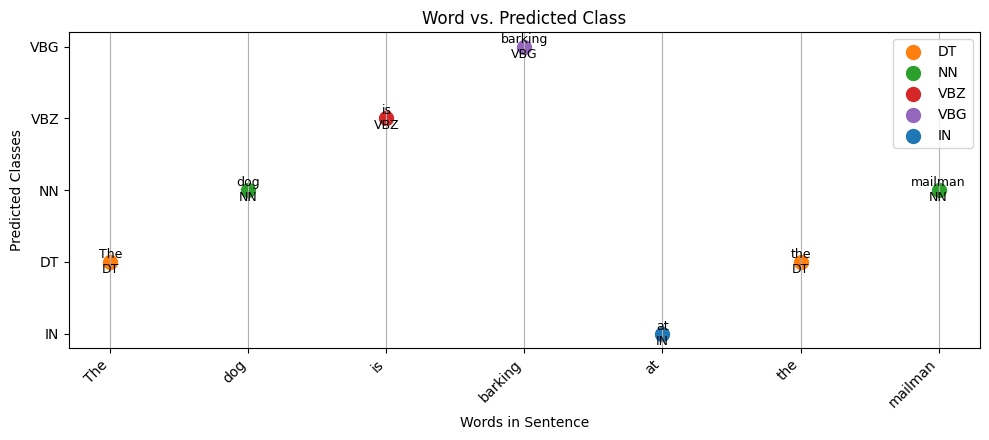

In [66]:
import matplotlib.pyplot as plt

def visualize_predictions(sent, predictions):
    # Remove the padding from the predictions
    predictions = predictions[1:-1]
    

    # Setting up the plot
    plt.figure(figsize=(10, 4.5))  # Increase the figure size for better readability
    plt.yticks(range(len(set(predictions))), list(set(predictions)))  # Set the y-ticks to the unique classes
    plt.xticks(range(len(sent)), sent, rotation=45, ha="right")  # Rotate x labels for better visibility

    # Colormap so each class has a different color
    cmap = plt.get_cmap('tab10')
    label2idx = {label: i for i, label in enumerate(set(predictions))}
    
    # Create a scatter plot with a point for each word-prediction pair
    for i, (word, pred) in enumerate(zip(sent, predictions)):
        plt.scatter(i, list(set(predictions)).index(pred), s=100, label=pred, color=cmap(label2idx[pred]))
        # Move the text down a bit for better visibility
        plt.text(i, list(set(predictions)).index(pred), f'{word}\n{pred}', fontsize=9,
                 ha='center', va='center')

    # Adding details
    plt.title('Word vs. Predicted Class')
    plt.xlabel('Words in Sentence')
    plt.ylabel('Predicted Classes')
    plt.grid(axis='x')

    # Show legend and plot
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates in legend
    plt.legend(by_label.values(), by_label.keys())
    plt.tight_layout()
    plt.show()

# Example usage with your function
# Assuming 'model', 'vec', and 'idx2class' are already defined and initialized
sentence = nltk.tokenize.word_tokenize(sent[0])
predictions = predict_sent(sentence, model, vec, idx2class)
visualize_predictions(sentence, predictions)


### Feature importance

In [38]:
list_features_original = features[0].keys()
print("The original features are: ", list_features_original)

# Obtain the range in the feature matrix for each feature
feature_ranges = {k:[] for k in list_features_original}
for i, name in enumerate(vec.get_feature_names_out()):
    feature_name = name.split('=')[0]
    feature_ranges[feature_name].append(i)

# Getting the min and max index for each feature
feature_ranges = {k: (min(v), max(v)) for k, v in feature_ranges.items()}
for k, v in feature_ranges.items():
    print(f"The range for the feature {k} is from {v[0]} to {v[1]}")

The original features are:  dict_keys(['word', 'dist_from_first', 'dist_from_last', 'capitalized', 'prefix1', 'prefix2', 'prefix3', 'suffix1', 'suffix2', 'suffix3', 'prev_word', 'next_word', 'numeric'])
The range for the feature word is from 29156 to 40174
The range for the feature dist_from_first is from 1 to 1
The range for the feature dist_from_last is from 2 to 2
The range for the feature capitalized is from 0 to 0
The range for the feature prefix1 is from 11101 to 11177
The range for the feature prefix2 is from 11178 to 11910
The range for the feature prefix3 is from 11911 to 15028
The range for the feature suffix1 is from 26045 to 26119
The range for the feature suffix2 is from 26120 to 26764
The range for the feature suffix3 is from 26765 to 29155
The range for the feature prev_word is from 15029 to 26044
The range for the feature next_word is from 3 to 11099
The range for the feature numeric is from 11100 to 11100


In [97]:
import numpy as np

importances = model.feature_importances_

# Aggregating the feature importances of the same original feature by summing them
feature_importances_original = {k: 0 for k in list_features_original}
for k, v in feature_ranges.items():
    feature_importances_original[k] = np.sum(importances[v[0]:v[1]+1])

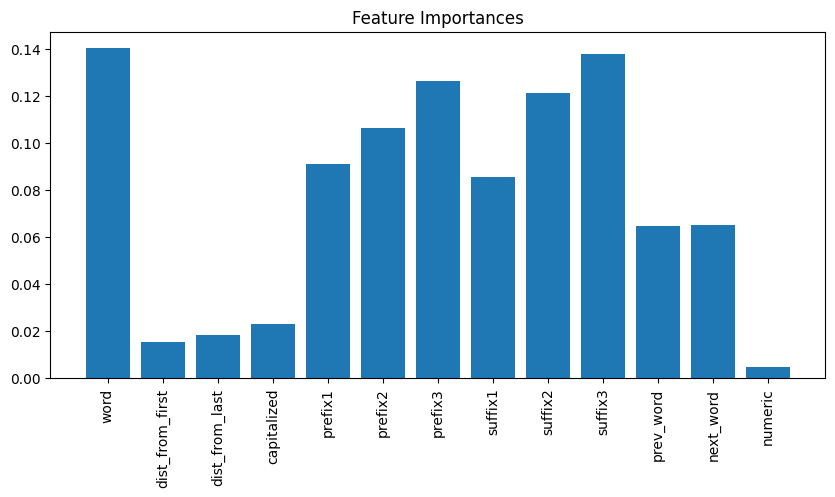

In [98]:
# Plot of the feature importances sum
keys = feature_importances_original.keys()
values = feature_importances_original.values()

plt.figure(figsize=(10, 4.5))
plt.bar(keys, values)
plt.xticks(rotation=90)
plt.title("Feature Importances")
plt.show()

